# IBM Developer Skills Network

# Convolutional Neural Network with Batch-Normalization

Like a fully connected network, we create a <code>BatchNorm2d</code> object, but we apply it to the 2D convolution object. First, we create objects <code>Conv2d</code> object; we require the number of output channels, specified by the variable <code>OUT</code>.  


<code>self.cnn1 = nn.Conv2d(in_channels=1, out_channels=OUT, kernel_size=5, padding=2) </code>


We then create a Batch Norm  object for 2D convolution as follows:

<code>self.conv1_bn = nn.BatchNorm2d(OUT)</code>

The parameter out is the number of channels in the output. We can then apply batch norm  after  the convolution operation :


<code>x = self.cnn1(x)</code>

<p></p>
 <code> x=self.conv1_bn(x)</code>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np


In [2]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

# Get the Data

In [3]:
IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [4]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [5]:
# Show the data type for each element in dataset

type(train_dataset[0][1])

int

In [6]:
# The label for the fourth data element

train_dataset[3][1]

1

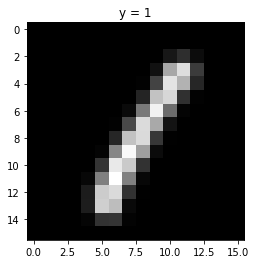

In [7]:
# The image for the fourth data element
show_data(train_dataset[3])

# Build a Two Convolutional Neural Network Class

In [8]:
class CNN(nn.Module):

    # Constructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [9]:
# add a batch norm
class CNN_batch(nn.Module):

    # Constructor
    def __init__(self, out_1=16, out_2=32, number_of_classes=10):
        super (CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)  
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2,kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)  # batch normalization applied before activation function
        x = torch.relu(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)

        return x

# GPU setup

In [10]:
torch.cuda.is_available()

True

In [11]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

# Train the model

In [12]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs=4):

    N_test = len(validation_dataset)
    accuracy_list = []
    loss_list = []

    for epoch in range(n_epochs):
        for x, y in train_loader:
            # sends features and labels to the GPU
            x, y = x.to(device), y.to(device)

            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)

        correct = 0
        # validation data
        for x_test, y_test in validation_loader:
            # sends features and labels to the GPU
            x_test, y_test = x_test.to(device), y_test.to(device)

            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
    
    return accuracy_list, loss_list


# Define the network

In [13]:
model = CNN(out_1=16, out_2=32)
model.to(device)

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

In [14]:
# Loss function
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [15]:
# Train the model without batch norm
accuracy_list_normal, loss_list_normal=train_model(model=model,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

In [16]:
# With batch norm
model_batch = CNN_batch(out_1=16, out_2=32)
model_batch.to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_batch.parameters(), lr=learning_rate)
accuracy_list_batch, loss_list_batch=train_model(model=model_batch,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

# Analyze results

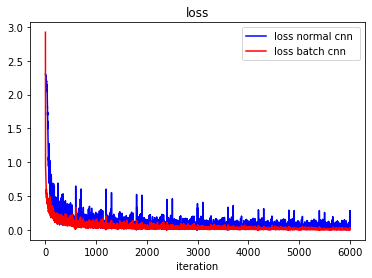

In [18]:
# Plot the loss and accuracy

loss_list_normal_cpu = []  # copy from device to host memory
for ll in loss_list_normal:
    loss_list_normal_cpu.append(ll.cpu())

loss_list_batch_cpu = []  # copy from device to host memory
for ll in loss_list_batch:
    loss_list_batch_cpu.append(ll.cpu())

plt.plot(loss_list_normal_cpu, 'b',label='loss normal cnn ')
plt.plot(loss_list_batch_cpu,'r',label='loss batch cnn')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()

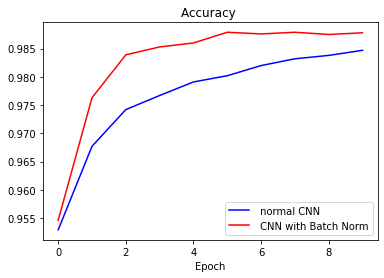

In [20]:
plt.plot(accuracy_list_normal, 'b',label=' normal CNN')
plt.plot(accuracy_list_batch,'r',label=' CNN with Batch Norm')
plt.xlabel('Epoch')
plt.title("Accuracy ")
plt.legend()
plt.show()

We see the CNN with batch norm performers better, with faster convergence.
